<a href="https://colab.research.google.com/github/zeroam/jupyter-notebook/blob/master/dive_into_deep_learning/3.12.weight_decay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install mxnet==1.6.0b20190915
!pip install d2l

In [0]:
%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [0]:
def init_params():
  w = nd.random.normal(scale=1, shape=(num_inputs, 1))
  b = nd.zeros(shape=(1,))
  w.attach_grad()
  b.attach_grad()
  return [w, b]

In [0]:
def l2_penalty(w):
  return (w**2).sum() / 2

def linreg(X, w, b):
    return nd.dot(X, w) + b

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
  d2l.set_figsize(figsize)
  d2l.plt.xlabel(x_label)
  d2l.plt.ylabel(y_label)
  d2l.plt.semilogy(x_vals, y_vals)
  if x2_vals and y2_vals:
    d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
    d2l.plt.legend(legend)

In [0]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = linreg, d2l.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(
    train_features, train_labels), batch_size, shuffle=True)

def fit_and_plot(lambd):
  w, b = init_params()
  train_ls, test_ls = [], []
  for _ in range(num_epochs):
    for X, y in train_iter:
      with autograd.record():
        # The L2 norm penalty term has been added
        l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
      l.backward()
      d2l.sgd([w, b], lr, batch_size)
    train_ls.append(loss(net(train_features, w, b),
                         train_labels).mean().asscalar())
    test_ls.append(loss(net(test_features, w, b), 
                        test_labels).mean().asscalar())
  semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
               range(1, num_epochs + 1), test_ls, ['train', 'test'])
  print('l2 norm of w:', w.norm().asscalar())

l2 norm of w: 14.293287


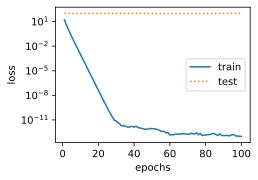

In [18]:
fit_and_plot(lambd=0)

In [0]:
def fit_and_plot_gluon(wd):
  net = nn.Sequential()
  net.add(nn.Dense(1))
  net.initialize(init.Normal(sigma=1))
  # The weight parameter has been decayed. Weight names generally
  # end with "weight"
  trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',
                            {'learning_rate': lr, 'wd': wd})
  # The bias parameter has not decayed. Bias names generally end with "bias"
  trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                            {'learning_rate': lr})
  
  train_ls, test_ls = [], []
  for _ in range(num_epochs):
    for X, y in train_iter:
      with autograd.record():
        l = loss(net(X), y)
      l.backward()
      # Call the step function on each of the two Trainer instances to
      # update the weight and bias separately
      trainer_w.step(batch_size)
      trainer_b.step(batch_size)
    train_ls.append(loss(net(train_features),
                         train_labels).mean().asscalar())
    test_ls.append(loss(net(test_features),
                        test_labels).mean().asscalar())
  semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
           range(1, num_epochs + 1), test_ls, ['train', 'test'])
  print('L2 norm of w:', net[0].weight.data().norm().asscalar())

L2 norm of w: 13.511566


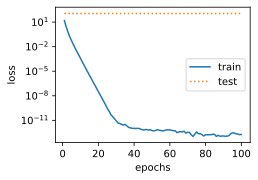

In [22]:
fit_and_plot_gluon(0)

L2 norm of w: 0.04396105


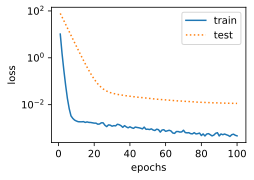

In [23]:
fit_and_plot_gluon(3)